In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import photutils
import datetime
from datetime import datetime, timedelta
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


import astropy
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
import glob 
import time
import astroalign as aa
import juliandate as jd

In [2]:
#Sets up df where data from different dates / filters can be stored
RV_Uma_df = pd.DataFrame(columns = ['File ID', 'x-pos', 'y-pos', 'Aperture Sum', 'Median Flux without bkg', 'Sum without bkg', 'Date and Time'])
StandardStar_df = pd.DataFrame(columns = ['File ID', 'x-pos', 'y-pos', 'Aperture Sum', 'Median Flux without bkg', 'Sum without bkg', 'Date and Time'])
RV_Uma_missed = []
StandardStar_missed = []

def GetData(filepath):
    
    #resets current image list
    image_list = []
    n = 0
    
    #Gets files in the filepath
    for file in glob.glob(filepath+"*.fits"):
        image_list.append(file)
        n=n+1
    #print("\n".join(image_list)) #Check all files have been found
    
    #Loops 
    for file in image_list:
        #Get the file
        image_file = get_pkg_data_filename(file)
        image_data = fits.getdata(image_file, ext=0)
    
        #Find file data
        fitsFile = fits.open(file)
        date_obs = fitsFile[0].header['DATE-OBS']
        filename = (file.replace(filepath,""))
        time = date_obs[11:19]
        date = date_obs[:10]
        data = fitsFile[0].data
        median = np.median(data)
    
        #setting up starfinder
        tol = 5*median
        fwhm = 10
        FindStars = DAOStarFinder(tol, fwhm)
    
        #finds the stars
        stars = FindStars(data)
    
        #loops through positions of stars and adds values to an array
        positions = []
        
        RV_Uma_added = False
        StandardStar_added = False
        
        for i in range(len(stars)):
            posn = (stars['xcentroid'][i], stars['ycentroid'][i])
            positions.append(posn)
        
            #Aperture and annulus set up
            aperture = CircularAperture((positions[i][0], positions[i][1]), r=3.5*fwhm)
            annulus = CircularAnnulus((positions[i][0], positions[i][1]), r_in=3.5*fwhm, r_out=(3.5*fwhm*np.sqrt(5)))
            aperstats = aperture_photometry(image_data, aperture)
            annulstats =  aperture_photometry(image_data, annulus)

            #Annulus set up and getting data
            annulus_masks = annulus.to_mask(method='center')
            annulus_data = annulus_masks.multiply(image_data)
            annulus_data_1d = annulus_data[annulus_masks.data > 0]
            median_bg = np.median(annulus_data_1d)
        
            #Apature data and set up
            aperture_masks = aperture.to_mask(method='center')
            aperture_data = aperture_masks.multiply(image_data)
            aperture_data_1d = aperture_data[aperture_masks.data > 0]
            
            #Calculations bkg sub etc
            flux = aperstats['aperture_sum'][0] - median_bg * aperture.area
            median_flux_bgsub = np.median(aperture_data_1d) - median_bg
            aperture_stats = ApertureStats(image_data, aperture)
            
            #Takes location of RV Uma and adds the data for it to the data frame 
            if ((1050 < stars['xcentroid'][i] < 1250) & ( 750 < stars['ycentroid'][i] < 1000)):
                RV_Uma_df.loc[len(RV_Uma_df)] = {'File ID': file,'x-pos': positions[i][0], 'y-pos': positions[i][1], 'Aperture Sum': aperstats['aperture_sum'][0], 'Median Flux without bkg': median_flux_bgsub, 'Sum without bkg':flux, 'Date and Time': date+" "+time}
                RV_Uma_added = True
            
            #Bit below is to selected TYC 3850-738-1
            elif ((250 < stars['xcentroid'][i] < 400) & ( 450 < stars['ycentroid'][i] < 600)):
                StandardStar_df.loc[len(StandardStar_df)] = {'File ID': file, 'x-pos': positions[i][0], 'y-pos': positions[i][1], 'Aperture Sum': aperstats['aperture_sum'][0], 'Median Flux without bkg': median_flux_bgsub, 'Sum without bkg':flux, 'Date and Time': date+" "+time}         
                StandardStar_added = True
        
        #adds file to missed list if the star counldn't be found
        if (RV_Uma_added == False):
            RV_Uma_missed.append(file)
        if(StandardStar_added == False):
            StandardStar_missed.append(file)
       
        print(file) #just to show progress
    
    print("\n",filepath, " has been added",)

In [3]:
"""
File pathway examples

RV_Uma:

"Sloan Data\\RV Uma\\2022_03_20\\Blue\\"
"Sloan Data\\RV Uma\\2022_03_22\\Blue\\"
"Sloan Data\\RV Uma\\2022_03_24\\Blue\\\"
---
"Sloan Data\\RV Uma\\2023_02_23\\Blue\\"
"Sloan Data\\RV Uma\\2023_04_03\\Blue\\"

For either Green, Red and Luminance just replace the "Blue part"
"""

'\nFile pathway examples\n\nRV_Uma:\n\n"Sloan Data\\RV Uma\\2022_03_20\\Blue\\"\n"Sloan Data\\RV Uma\\2022_03_22\\Blue\\"\n"Sloan Data\\RV Uma\\2022_03_24\\Blue\\"\n---\n"Sloan Data\\RV Uma\\2023_02_23\\Blue\\"\n"Sloan Data\\RV Uma\\2023_04_03\\Blue\\"\n\nFor either Green, Red and Luminance just replace the "Blue part"\n'

In [4]:
GetData("..\\RV Uma\\2022_03_20\\Blue\\")
GetData("..\\RV Uma\\2022_03_22\\Blue\\")
GetData("..\\RV Uma\\2022_03_24\\Blue\\")
GetData("..\\RV Uma\\2023_02_23\\RV_UMa\\Light\\Blue\\")
GetData("..\\RV Uma\\2023_04_03\\RV_UMa\\Light\\Blue\\")

..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_001.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_002.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_003.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_004.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_005.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_006.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_007.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_008.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_009.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_010.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_011.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_012.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_013.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_014.fits
..\RV Uma\2022_03_20\Blue\Reduced_

..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_004.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_005.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_006.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_007.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_008.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_009.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_010.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_011.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_012.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_013.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_014.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_015.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_016.fits
..\RV Uma\2022_03_24\Blue\Reduced_RV_Uma_Light_Blue_32_secs_017.fits
..\RV Uma\2022_03_24\Blue\Reduced_

In [5]:
#print("Where RV_UMa is missing: ", RV_Uma_missed)
#print("Where Standard Star is missing: ", StandardStar_missed)

#removes Standard stars data where RV_Uma is missing and vise versa
for i in range (len(RV_Uma_missed)):
    StandardStar_df.drop(StandardStar_df.index[(StandardStar_df['File ID'] == RV_Uma_missed[i])], axis=0,inplace=True)

for i in range (len(StandardStar_missed)):
    RV_Uma_df.drop(RV_Uma_df.index[(RV_Uma_df['File ID'] == StandardStar_missed[i])], axis=0, inplace=True)
    
#Resets the index so it can loop and match up with eachother correctly
RV_Uma_df = RV_Uma_df.reset_index(drop=True) #The drop stops the old index from being added as a new column
StandardStar_df = StandardStar_df.reset_index(drop=True)

In [6]:
#Finding the mean of the standard star sum
StandardStarMean = StandardStar_df['Sum without bkg'].mean()

#finding the differeance between the points and it's average
StandardStar_df['Dif'] = StandardStarMean - StandardStar_df['Sum without bkg']

#Move all the standard star points so they are on the same line by correction
StandardStar_df['Corrected Sum'] = StandardStar_df['Sum without bkg'] + StandardStar_df['Dif']
RV_Uma_df['Corrected Sum'] = RV_Uma_df['Sum without bkg'] + StandardStar_df['Dif']

#Caculating instrumental mag
RV_Uma_df['Instrumental Magnitude'] = -2.5*np.log10(RV_Uma_df['Corrected Sum'])
StandardStar_df['Instrumental Magnitude'] = -2.5*np.log10(StandardStar_df['Corrected Sum'])

In [7]:
StandardStar_df
StandardStar_mean = np.mean(StandardStar_df['Corrected Sum'])
StandardStar_mean

1400.9742871849219

In [8]:
RV_Uma_df
RV_Uma_mean = np.mean(RV_Uma_df['Corrected Sum'])
RV_Uma_mean

3408.6240730941495

In [9]:
Average_instrumental = -2.5*np.log10(StandardStar_mean)
StandardStar_df['Average_instrumental'] = Average_instrumental - StandardStar_df['Instrumental Magnitude']
StandardStar_df['Correct instrumental'] =  StandardStar_df['Average_instrumental'] + StandardStar_df['Instrumental Magnitude']
StandardStar_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Dif,Corrected Sum,Instrumental Magnitude,Average_instrumental,Correct instrumental
0,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,305.872811,527.902336,5483.753901,0.031997,1626.344018,2022-03-20 21:32:52,-225.369731,1400.974287,-7.866075,8.881784e-16,-7.866075
1,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,305.956345,527.241315,5649.434698,0.037155,1611.579128,2022-03-20 21:35:15,-210.604840,1400.974287,-7.866075,8.881784e-16,-7.866075
2,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,306.643075,526.260708,5801.750472,0.026208,1603.797317,2022-03-20 21:37:38,-202.823030,1400.974287,-7.866075,8.881784e-16,-7.866075
3,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,306.161585,526.005599,5970.594340,0.042642,1618.436976,2022-03-20 21:39:57,-217.462689,1400.974287,-7.866075,8.881784e-16,-7.866075
4,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,310.622716,535.946176,6138.572273,0.042401,1619.627754,2022-03-20 21:42:18,-218.653467,1400.974287,-7.866075,8.881784e-16,-7.866075
...,...,...,...,...,...,...,...,...,...,...,...,...
162,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,302.573823,481.452210,12204.151856,0.022856,708.637453,2023-04-03 23:12:01,692.336834,1400.974287,-7.866075,8.881784e-16,-7.866075
163,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,297.059493,490.392025,11836.862071,0.022901,706.645541,2023-04-03 23:26:40,694.328746,1400.974287,-7.866075,8.881784e-16,-7.866075
164,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,287.181944,501.105944,11762.459722,0.024729,725.259034,2023-04-03 23:39:18,675.715253,1400.974287,-7.866075,8.881784e-16,-7.866075
165,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,282.970991,495.685742,11633.762742,0.016801,700.036043,2023-04-03 23:52:18,700.938244,1400.974287,-7.866075,8.881784e-16,-7.866075


In [10]:
RV_Uma_df['Correct Instrumental'] = StandardStar_df['Average_instrumental'] + RV_Uma_df['Instrumental Magnitude']
RV_Uma_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Corrected Sum,Instrumental Magnitude,Correct Instrumental
0,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1147.707396,899.882395,6334.737573,0.049164,2480.566385,2022-03-20 21:32:52,2255.196653,-8.382961,-8.382961
1,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1147.884025,899.299865,6489.277528,0.052171,2474.155901,2022-03-20 21:35:15,2263.551060,-8.386976,-8.386976
2,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1148.496245,898.304356,6712.227639,0.048710,2516.525674,2022-03-20 21:37:38,2313.702644,-8.410769,-8.410769
3,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1148.037925,897.869755,6872.333602,0.047577,2530.963553,2022-03-20 21:39:57,2313.500864,-8.410674,-8.410674
4,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1152.603318,907.976096,7091.254786,0.057041,2583.655218,2022-03-20 21:42:18,2365.001752,-8.434579,-8.434579
...,...,...,...,...,...,...,...,...,...,...
162,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1168.754399,904.098688,14031.090258,0.053747,2805.104341,2023-04-03 23:12:01,3497.441176,-8.859376,-8.859376
163,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1163.194514,913.180422,13674.645730,0.048796,2813.680129,2023-04-03 23:26:40,3508.008875,-8.862652,-8.862652
164,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1153.217916,923.950578,13626.094876,0.057802,2841.434839,2023-04-03 23:39:18,3517.150092,-8.865477,-8.865477
165,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1148.911967,918.696993,13580.151716,0.050534,2903.063411,2023-04-03 23:52:18,3604.001656,-8.891962,-8.891962


In [11]:
def Phase(DataFrame, Period):

    #Only work if the column is added first for some reason
    DataFrame['Phase'] = 0
    
    for i in range(len(DataFrame)):
    #Picks out corresponding values
        year = int((DataFrame['Date and Time'][i])[0:4])
        month = int((DataFrame['Date and Time'][i])[5:7])
        day = int((DataFrame['Date and Time'][i])[8:10])
        hour = int((DataFrame['Date and Time'][i])[11:13])
        minute = int((DataFrame['Date and Time'][i])[14:16])
        second = int((DataFrame['Date and Time'][i])[17:19])

        #Caculates Julian Date and phase
        J_D = jd.from_gregorian(year, month, day, hour, minute, second, 0)
        P = ((J_D/Period) - np.floor(J_D/Period))

        #Adds the phase 
        DataFrame['Phase'][i] = P

In [12]:
Period = 0.468060 #of RV_Uma

Phase(RV_Uma_df, Period)
Phase(StandardStar_df, Period)

C:\Users\al2278\AppData\Local\Temp\ipykernel_28588\2557929103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame['Phase'][i] = P
C:\Users\al2278\AppData\Local\Temp\ipykernel_28588\2557929103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame['Phase'][i] = P


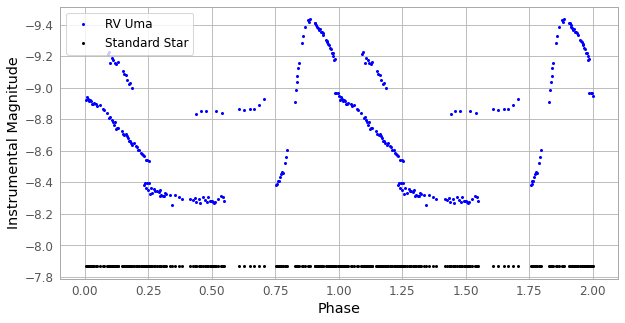

In [13]:
#Plots counts agasint time of
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

"""
#In flux
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Corrected Sum'], marker = 'o', markersize=2, color = 'blue', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Corrected Sum'], marker = 'o', markersize=2, color = 'blue', linestyle='none') 

ax.plot(StandardStar_df['Phase'], StandardStar_df['Corrected Sum'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Corrected Sum'], marker = 'o', markersize=2, color = 'black', linestyle='none') 
ax.set_ylabel('Flux')
"""

#In Instrumental Magnitude
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Correct Instrumental'], marker = 'o', markersize=2, color = 'blue', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Correct Instrumental'], marker = 'o', markersize=2, color = 'blue', linestyle='none') 

ax.plot(StandardStar_df['Phase'], StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none') 


ax.invert_yaxis()
ax.set_ylabel('Instrumental Magnitude')

ax.set_xlabel('Phase')

ax.legend()

In [14]:
RV_Uma_df.to_csv('RV_Uma.csv') # transforms df into a cvs file and saves it to computer
StandardStar_df.to_csv('StandardStar.csv')

#RV_Uma_df
#StandardStar_df

In [22]:
apparent_mag_blue = 10.97
offset = apparent_mag_blue - Average_instrumental
RV_Uma_df['Apparent Magnitude'] = RV_Uma_df['Correct Instrumental'] + offset
RV_Uma_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Corrected Sum,Instrumental Magnitude,Correct Instrumental,Phase,Apparent Magnitude
0,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1147.707396,899.882395,6334.737573,0.049164,2480.566385,2022-03-20 21:32:52,2255.196653,-8.382961,-8.382961,0.754912,10.453114
1,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1147.884025,899.299865,6489.277528,0.052171,2474.155901,2022-03-20 21:35:15,2263.551060,-8.386976,-8.386976,0.758448,10.449100
2,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1148.496245,898.304356,6712.227639,0.048710,2516.525674,2022-03-20 21:37:38,2313.702644,-8.410769,-8.410769,0.761984,10.425307
3,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1148.037925,897.869755,6872.333602,0.047577,2530.963553,2022-03-20 21:39:57,2313.500864,-8.410674,-8.410674,0.765421,10.425401
4,..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light...,1152.603318,907.976096,7091.254786,0.057041,2583.655218,2022-03-20 21:42:18,2365.001752,-8.434579,-8.434579,0.768908,10.401497
...,...,...,...,...,...,...,...,...,...,...,...,...
162,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1168.754399,904.098688,14031.090258,0.053747,2805.104341,2023-04-03 23:12:01,3497.441176,-8.859376,-8.859376,0.627266,9.976699
163,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1163.194514,913.180422,13674.645730,0.048796,2813.680129,2023-04-03 23:26:40,3508.008875,-8.862652,-8.862652,0.649002,9.973424
164,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1153.217916,923.950578,13626.094876,0.057802,2841.434839,2023-04-03 23:39:18,3517.150092,-8.865477,-8.865477,0.667746,9.970598
165,..\RV Uma\2023_04_03\RV_UMa\Light\Blue\Reduced...,1148.911967,918.696993,13580.151716,0.050534,2903.063411,2023-04-03 23:52:18,3604.001656,-8.891962,-8.891962,0.687033,9.944113


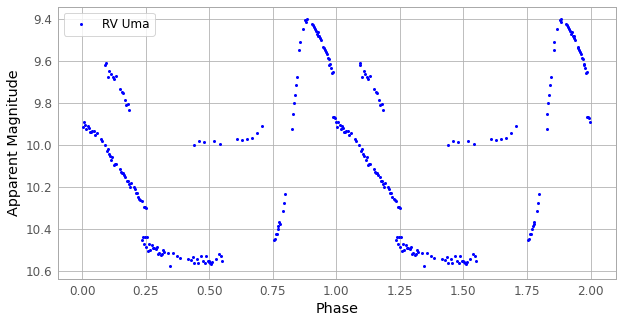

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

#In Instrumental Magnitude
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Apparent Magnitude'], marker = 'o', markersize=2, color = 'blue', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Apparent Magnitude'], marker = 'o', markersize=2, color = 'blue', linestyle='none') 

#ax.plot(StandardStar_df['Phase'], StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
#ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none') 


ax.invert_yaxis()
ax.set_ylabel('Apparent Magnitude')

ax.set_xlabel('Phase')

ax.legend()

## green

In [24]:
a = -0.97
b = -2.2

Magnitude = a + b*np.log10(Period)
Magnitude

-0.2446633622270168

In [21]:
d = ((apparent_mag_blue + Magnitude) + 5)/5
distance = 10**d
distance

1326.5857490782162